# Comparing one month of LO versus CIOPS

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import cmocean as cm
import math 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
# section names (same for both)
sec_meander = 0
init = 1
sec_north = 2
sec_south= 4
sec_offshore = 3

In [3]:
tide = 24
sdep = -100

In [4]:
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='lightgray')
    return(pc)

def FluxEW(mydata, section, lonW, lonE, fjgrid, maxdepth, ax):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = np.abs(np.max(mydata.init_t)-np.min(mydata.init_t))
    
    f_lons = mymesh.glamf[0, igrid]
    u_lons = mymesh.glamv[0, igrid]
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum())).values
    f_dist = f_lons/m2lon
    w_depths = mymesh.gdepw_1d
    xs, ys = np.meshgrid(np.array(f_lons[lonW-1:lonE+1]), np.array(w_depths[0]))
    
    gridding = 1
    tick = 0.01
    units = '$m^3 \, s^{-1} m^{-2}$'
    
    cmap = cm.cm.speed
    cmap.set_under('white')
    
    t_min = 0.00000000001
 
    lons = mydata.final_lon[(mydata.final_section==section)]
    dist = f_lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    t_max = (tick/np.sum(transports)).values/m2lon
        
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(f_lons[lonW-1:lonE+1:gridding]), 
                                    w_depths[0]],weights= transports, cmap=cmap, vmin = t_min, vmax=t_max, density= True)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    distance = abs(round_to_3((f_dist[lonW-1]-f_dist[lonE+1]).values/1000))
    ax.set_xlabel(str(distance)[:-2]+" km")

    pc = draw_patches(fmask, lonW-2, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([u_lons[lonW+2], u_lons[lonE-2]])
    ax.set_xticklabels(np.round([u_lons[lonW+2], u_lons[lonE-2]],2))
    ax.set_xlim((u_lons[lonW], u_lons[lonE]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title))
    ax.set_yticklabels([])
    mydata.close()

    return m2lon

def FluxEW_ROMS(mydata, section, y, xmin, xmax, maxdepth, m2lon, ax):
    
    units = '$m^3 \, s^{-1} m^{-2}$'
    
    time = np.abs(np.max(mydata.init_t)-np.min(mydata.init_t))


    cmap = cm.cm.speed
    cmap.set_under('white')
    

    
    depths = mydata.final_depth[(mydata.final_section==section)]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    lons = mydata.final_lon[(mydata.final_section==section)]
    
    t_min = 0.000000000001
    tick = 0.01
    t_max = (tick/np.sum(transports)).values/m2lon
        
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(mymesh.lon_rho[y,xmin-1:xmax+1]), 
                                    np.arange(0,np.max(mymesh.h[y,xmin:xmax]),10)],weights= transports, 
                                    cmap=cm.cm.speed, vmin = t_min, vmax=t_max, density= True)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    distance = round_to_3(_distance_(mymesh.lat_rho[y,xmin],mymesh.lat_rho[y,xmax],mymesh.lon_rho[y,xmin],mymesh.lon_rho[y,xmax]))
    ax.set_xlabel(str(distance)[:-2]+" km")

    ax.fill_between(mymesh.lon_rho[y,xmin-1:xmax+1],mymesh.h[y,xmin-1:xmax+1], 500, color='lightgray')

    ax.invert_yaxis()
    ax.set_xticks([mymesh.lon_rho[y,xmin+2], mymesh.lon_rho[y,xmax-2]])
    ax.set_xticklabels(np.round([mymesh.lon_rho[y,xmin+2], mymesh.lon_rho[y,xmax-2]],2))
    ax.set_xlim((mymesh.lon_rho[y,xmin], mymesh.lon_rho[y,xmax]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(round_to_2(np.sum(transports).values))[:-2]+" "+units
    ax.set_title(str(full_title))
    mydata.close()

def _distance_(lat1,lat2,lon1,lon2):
    """
    Calculate the Haversine distance.
    Returns
    -------
    distance_in_km : float
    """
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

## Feb 2018

In [5]:
lo = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/20180309ariane_positions_quantitative.nc')
ci = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS-BC12/test_09mar18/ariane_positions_quantitative.nc')

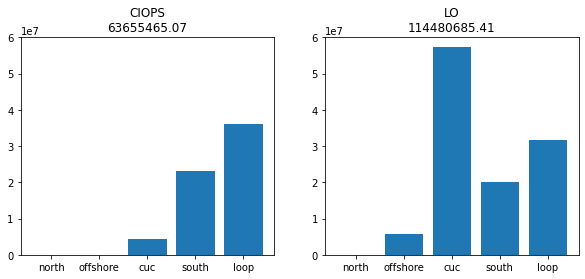

In [6]:
fig, ax = plt.subplots(1,2, figsize=[10,4])

#ciops
data = ci
north = np.sum(data.init_transp[(data.final_section==sec_north)])
offshore = np.sum(data.init_transp[(data.final_section==sec_offshore)])
cuc = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth <= sdep)])
south = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth > sdep)])
loop = np.sum(data.init_transp[(data.final_section==sec_meander) & (data.init_t-data.final_t > tide)])

ax[0].bar(['north','offshore','cuc','south','loop'],[north,offshore,cuc,south,loop],)
ax[0].set_title('CIOPS\n'+str(np.round(np.sum([north,offshore,cuc,south,loop]),2)))
ax[0].set_ylim([0,6*(10**7)])


#LO
data = lo
north = np.sum(data.init_transp[(data.final_section==sec_north)])
offshore = np.sum(data.init_transp[(data.final_section==sec_offshore)])
cuc = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth >= -sdep)])
south = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth < -sdep)])
loop = np.sum(data.init_transp[(data.final_section==sec_meander) & (data.init_t-data.final_t > tide)])

ax[1].bar(['north','offshore','cuc','south','loop'],[north,offshore,cuc,south,loop],)
ax[1].set_title('LO\n'+str(np.round(np.sum([north,offshore,cuc,south,loop]),2)))
ax[1].set_ylim([0,6*(10**7)]);


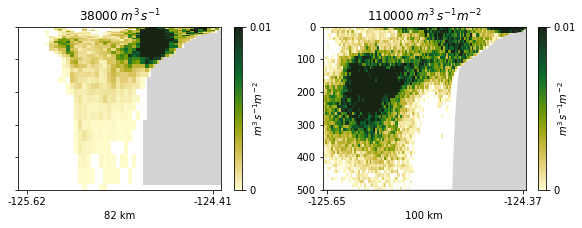

In [7]:
# cross sections of where CIOPS is coming in
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

fig, ax = plt.subplots(1,2,figsize=(10,3))

m2lon = FluxEW(ci, sec_south, 595, 644, 199, 500, ax[0])

# cross sections of where LO is coming in
mymesh = xr.open_dataset('./grid.nc')

y = 706
xmin=192
xmax=318

FluxEW_ROMS(lo, sec_south, y, xmin, xmax, 500, m2lon, ax[1])

## Aug 2017

In [8]:
lo = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/20170902ariane_positions_quantitative.nc')
ci = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS-BC12/test_01sep17/ariane_positions_quantitative.nc')

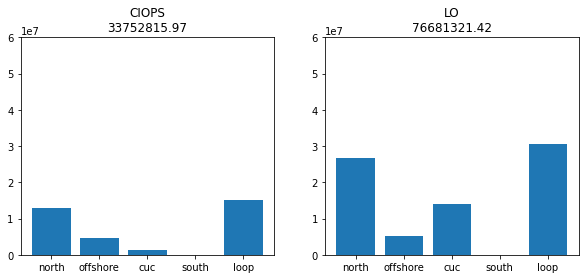

In [9]:
fig, ax = plt.subplots(1,2, figsize=[10,4])

#ciops
data = ci
north = np.sum(data.init_transp[(data.final_section==sec_north)])
offshore = np.sum(data.init_transp[(data.final_section==sec_offshore)])
cuc = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth <= sdep)])
south = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth > sdep)])
loop = np.sum(data.init_transp[(data.final_section==sec_meander) & (data.init_t-data.final_t > tide)])

ax[0].bar(['north','offshore','cuc','south','loop'],[north,offshore,cuc,south,loop],)
ax[0].set_title('CIOPS\n'+str(np.round(np.sum([north,offshore,cuc,south,loop]),2)))
ax[0].set_ylim([0,6*(10**7)])


#LO
data = lo
north = np.sum(data.init_transp[(data.final_section==sec_north)])
offshore = np.sum(data.init_transp[(data.final_section==sec_offshore)])
cuc = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth >= -sdep)])
south = np.sum(data.init_transp[(data.final_section==sec_south) & (data.final_depth < -sdep)])
loop = np.sum(data.init_transp[(data.final_section==sec_meander) & (data.init_t-data.final_t > tide)])

ax[1].bar(['north','offshore','cuc','south','loop'],[north,offshore,cuc,south,loop],)
ax[1].set_title('LO\n'+str(np.round(np.sum([north,offshore,cuc,south,loop]),2)))
ax[1].set_ylim([0,6*(10**7)]);

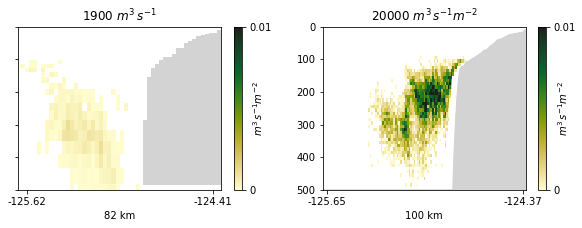

In [10]:
# cross sections of where CIOPS is coming in in the south
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

fig, ax = plt.subplots(1,2,figsize=(10,3))

m2lon = FluxEW(ci, sec_south, 595, 644, 199, 500, ax[0])

# and LiveOcean
mymesh = xr.open_dataset('./grid.nc')

y = 706
xmin=192
xmax=318

FluxEW_ROMS(lo, sec_south, y, xmin, xmax, 500, m2lon, ax[1])

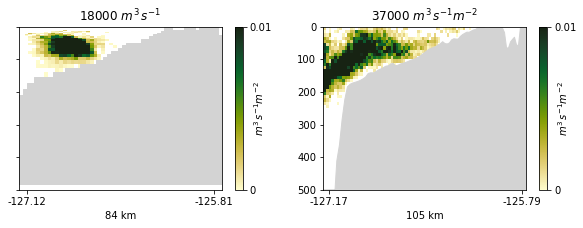

In [12]:
# cross sections of where CIOPS is coming in in the north
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

fig, ax = plt.subplots(1,2,figsize=(10,3))

m2lon = FluxEW(ci, sec_north, 532, 585, 321, 500, ax[0])

# and LiveOcean
mymesh = xr.open_dataset('./grid.nc')

y = 1102
xmin=98  #73
xmax=186 #161

FluxEW_ROMS(lo, sec_north, y, xmin, xmax, 500, m2lon, ax[1])